In [1]:
import os
import csv
import numpy as np
import pandas as pd
import gc
import random
import string
import inflect
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
#from transformers import T5ForConditionalGeneration, T5Tokenizer
#from bert_score import BERTScorer
from rouge import Rouge
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments, AdamW
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import warnings
import pickle
import sys
from torch.cuda.amp import GradScaler, autocast
from tqdm.notebook import tqdm as notebook_tqdm

In [2]:
sys.setrecursionlimit(4000)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
warnings.filterwarnings("ignore")

In [5]:
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [6]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
def lowercase_text(text):
    return text.lower()

def tokenize_text(text):
    return word_tokenize(text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Initialize inflect engine
p = inflect.engine()

# Convert numbers to words with error handling for large numbers
def convert_numbers_in_text(text):
    words = text.split()
    new_words = []
    
    for word in words:
        if word.isdigit():
            try:
                word_in_words = p.number_to_words(word)
            except Exception:  # Catch any exception, including out-of-range numbers
                word_in_words = word  # Leave the number unchanged if there's an error
            new_words.append(word_in_words)
        else:
            new_words.append(word)
    
    return ' '.join(new_words)

# Main preprocessing function
def preprocess_text(text):
    text = lowercase_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    text = convert_numbers_in_text(text)  # Combined the number conversion here
    return text

# Access and preprocess text from document and summary files
def access_and_preprocess_text(doc_file_path, summary_file_path):
    with open(doc_file_path, 'r', encoding='utf-8') as doc_file:
        doc_text = doc_file.read()
        processed_doc_text = preprocess_text(doc_text)

    with open(summary_file_path, 'r', encoding='utf-8') as summary_file:
        summary_text = summary_file.read()
        processed_summary_text = preprocess_text(summary_text)

    return processed_doc_text, processed_summary_text

In [8]:
# Initialize empty lists for training documents (X_train) and summaries (y_train)
X_train = []
y_train = []

# Initialize empty lists for testing documents (X_test) and summaries (y_test)
X_test = []
y_test = []

In [9]:
# Directories for training and testing documents and summaries
train_doc_folder = r"C:/Users/jelly/Desktop/Sem-4/SML/Research Paper/train_data/judgement"
train_summary_folder = r"C:/Users/jelly/Desktop/Sem-4/SML/Research Paper/train_data/summary"
test_doc_folder = r"C:/Users/jelly/Desktop/Sem-4/SML/Research Paper/test_data/judgement"
test_summary_folder = r"C:/Users/jelly/Desktop/Sem-4/SML/Research Paper/test_data/summary"

In [10]:
# Specify the number of training and testing documents to process
num_train_documents = 7030
num_test_documents = 100

In [11]:
# Get list of training and testing document files
train_doc_files = os.listdir(train_doc_folder)
train_summary_files = os.listdir(train_summary_folder)
test_doc_files = os.listdir(test_doc_folder)
test_summary_files = os.listdir(test_summary_folder)

In [13]:
# Process the specified number of training documents and collect X_train and y_train
for i in range(num_train_documents):
    doc_file = train_doc_files[i]
    summary_file = train_summary_files[i]
    processed_doc_text, processed_summary_text = access_and_preprocess_text(os.path.join(train_doc_folder, doc_file), os.path.join(train_summary_folder, summary_file))
    X_train.append(processed_doc_text)
    y_train.append(processed_summary_text)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
# Process the specified number of testing documents and collect X_test and y_test
for i in range(num_test_documents):
    doc_file = test_doc_files[i]
    summary_file = test_summary_files[i]
    processed_doc_text, processed_summary_text = access_and_preprocess_text(os.path.join(test_doc_folder, doc_file), os.path.join(test_summary_folder, summary_file))
    X_test.append(processed_doc_text)
    y_test.append(processed_summary_text)

In [15]:
# Setting up validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [16]:
print(f"Total Training Documents: {len(X_train)}")
print(f"Total Validation Documents: {len(X_val)}")
print(f"Total Testing Documents: {len(X_test)}")
print(f"Total Training Summaries: {len(y_train)}")
print(f"Total Validation Summaries: {len(y_val)}")
print(f"Total Testing Summaries: {len(y_test)}")

Total Training Documents: 5465
Total Validation Documents: 1822
Total Testing Documents: 100
Total Training Summaries: 5465
Total Validation Summaries: 1822
Total Testing Summaries: 100


In [17]:
# Define the TF-IDF vectorizer with updated parameters
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))

# Vectorize the training, validation, and testing data
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

y_train_tfidf = tfidf.fit_transform(y_train)
y_val_tfidf = tfidf.transform(y_val)
y_test_tfidf = tfidf.transform(y_test)

In [18]:
"""
# Load the BART model and tokenizer
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')


# Load the T5 model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-large')
tokenizer = T5Tokenizer.from_pretrained('t5-large')
"""
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Load the DistilBART model and tokenizer
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Enable gradient checkpointing to save memory
model.gradient_checkpointing_enable()

In [19]:
torch.cuda.empty_cache()
allocated_memory = torch.cuda.memory_allocated()
# Get the current GPU memory reserved (including overhead)
reserved_memory = torch.cuda.memory_reserved()

# Print memory in MB
print(f"Allocated memory: {allocated_memory / (1024 ** 2):.2f} MB")
print(f"Reserved memory: {reserved_memory / (1024 ** 2):.2f} MB")

# Get the free memory (total - reserved memory)
free_memory = torch.cuda.get_device_properties(0).total_memory - reserved_memory
print(f"Free memory: {free_memory / (1024 ** 2):.2f} MB")

Allocated memory: 1550.07 MB
Reserved memory: 1560.00 MB
Free memory: 6627.50 MB


In [20]:
def preprocess_for_training(doc_texts, summaries):
    # Reduce max_length to 512 for smaller memory footprint
    inputs = tokenizer(doc_texts, max_length=512, truncation=True, padding=True, return_tensors='pt')
    labels = tokenizer(summaries, max_length=150, truncation=True, padding=True, return_tensors='pt').input_ids
    return inputs, labels

# Convert data to appropriate format
train_encodings, train_labels = preprocess_for_training(X_train, y_train)
val_encodings, val_labels = preprocess_for_training(X_val, y_val)

# Dataset class
class SummaryDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = SummaryDataset(train_encodings, train_labels)
val_dataset = SummaryDataset(val_encodings, val_labels)

# Create DataLoaders with batch_size=1 for reduced memory usage
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)
scaler = GradScaler()

# Define gradient accumulation steps to simulate larger batch sizes
accumulation_steps = 4  # Adjust this as needed based on memory

# Training loop with tqdm
num_epochs = 3
model.train()

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()  # Reset gradients at the start of the epoch
    progress_bar = notebook_tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)

    for i, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps  # Normalize loss for gradient accumulation

        scaler.scale(loss).backward()

        # Perform optimizer step every few steps
        if (i + 1) % accumulation_steps == 0:
            torch.cuda.synchronize()  # Ensure operations complete before moving forward
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()  # Clear gradients after step

        progress_bar.set_postfix(loss=loss.item())

        del input_ids
        del attention_mask
        del labels
        del outputs
        del loss

        # Clear GPU cache periodically
        if (i + 1) % 10 == 0:  # Adjust the frequency as needed
            torch.cuda.empty_cache()

    # Print GPU memory usage to monitor consumption
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")
    print(f"Reserved memory: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")

    print(f'Epoch {epoch + 1} completed')

# Save the fine-tuned model and tokenizer
model.save_pretrained('bart-finetuned')
tokenizer.save_pretrained('bart-finetuned')

Epoch 1/3:   0%|          | 0/5465 [00:00<?, ?it/s]

Allocated memory: 6215.94 MB
Reserved memory: 7344.00 MB
Epoch 1 completed


Epoch 2/3:   0%|          | 0/5465 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [67]:
def summarize(text, maxSummarylength=500):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True).to(device)  # Move input to GPU
    with autocast():
        summary_ids = model.generate(inputs, max_length=maxSummarylength, min_length=int(maxSummarylength / 5), length_penalty=10.0, num_beams=2, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    
    # Clean up
    del inputs
    summary_ids = summary_ids.cpu()  # Move summary_ids back to CPU before deletion
    del summary_ids
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

    
    return summary


def split_text_into_pieces(text, max_tokens=600, overlapPercent=10):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)

    # Calculate the overlap in tokens
    overlap_tokens = int(max_tokens * overlapPercent / 100)

    # Split the tokens into chunks of size max_tokens with overlap
    pieces = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens - overlap_tokens)]

    # Convert the token pieces back into text
    text_pieces = [tokenizer.decode(tokenizer.convert_tokens_to_ids(piece), skip_special_tokens=True) for piece in pieces]

    return text_pieces

def summarize_chunks(text, max_length=500):
    tokens = tokenizer.tokenize(text)
    expectedCountOfChunks = len(tokens) / max_length
    max_length = int(len(tokens) / expectedCountOfChunks) + 2

    pieces = split_text_into_pieces(text, max_tokens=max_length)
    print("Number of pieces:", len(pieces))
    
    summaries = []
    for piece in pieces:
        summary = summarize(piece, maxSummarylength=150)
        summaries.append(summary)
    
    concatenated_summary = ' '.join(summaries)
    print(concatenated_summary)
    
    # Clean up
    del pieces
    del summaries
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    
    return concatenated_summary

In [68]:
def rouge_scores(actual_summary, predicted_summary):
    rouge = Rouge()
    scores = rouge.get_scores(predicted_summary, actual_summary)
    return scores[0]['rouge-1']['f'], scores[0]['rouge-2']['f'], scores[0]['rouge-l']['f']

In [69]:
# Function to clear GPU memory
def clear_gpu_memory():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    gc.collect()# Ensure all GPU operations are finished

In [70]:
clear_gpu_memory()

In [71]:
torch.cuda.empty_cache()
allocated_memory = torch.cuda.memory_allocated()
# Get the current GPU memory reserved (including overhead)
reserved_memory = torch.cuda.memory_reserved()

# Print memory in MB
print(f"Allocated memory: {allocated_memory / (1024 ** 2):.2f} MB")
print(f"Reserved memory: {reserved_memory / (1024 ** 2):.2f} MB")

# Get the free memory (total - reserved memory)
free_memory = torch.cuda.get_device_properties(0).total_memory - reserved_memory
print(f"Free memory: {free_memory / (1024 ** 2):.2f} MB")

Allocated memory: 6232.75 MB
Reserved memory: 6476.00 MB
Free memory: 1711.50 MB


In [74]:
csv_file = "train_evaluation.csv"

# Open the CSV file and write the headers
with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["document", "actual_summary", "predicted_summary", "cosine_similarity", "rouge_1", "rouge_2", "rouge_L"])  # Add headers
    
    # Iterate over 30 documents
    for i in tqdm(range(5), desc="Processing Documents", leave=False):
        print(f"\n### Document: {i+1} ###\n")
        
        # Generate summary for the document
        summary = summarize_chunks(X_train[i])
        
        # Compute cosine similarity using TF-IDF vectors (ensure `tfidf` is already defined and fitted)
        cosine_sim = cosine_similarity(tfidf.transform([y_train[i]]), tfidf.transform([summary]))[0][0]
        
        # Compute ROUGE scores (assuming rouge_scores is a predefined function)
        rouge_1, rouge_2, rouge_L = rouge_scores(y_train[i], summary)
        
        # Print metrics for inspection
        print(f"\nCosine similarity: {cosine_sim}")
        print(f"ROUGE-1: {rouge_1}")
        print(f"ROUGE-2: {rouge_2}")
        print(f"ROUGE-L: {rouge_L}\n")
        
        # Write the data to CSV file
        writer.writerow([X_train[i], y_train[i], summary, cosine_sim, rouge_1, rouge_2, rouge_L])
        
        # Clear memory for unused variables
        del summary
        del cosine_sim
        del rouge_1
        del rouge_2
        del rouge_L
        
        # Explicitly clear GPU memory and trigger garbage collection
        clear_gpu_memory()

print("Processing and evaluation completed.")

Processing Documents:   0%|          | 0/5 [00:00<?, ?it/s]


### Document: 1 ###

Number of pieces: 7
one thousand, nine hundred and fifty-nine levying tax passenger good carried road motor vehicle power enact act purport derived entry fifty-six state list sch vii constitution act received assent president rajasthan gazette april thirty one thousand,nine hundred and thirty-nine day rule framed exercise power conferred section twenty-one act also published notification also issued rule subsequently amended concerned rule amended deal case convenient see act constructed five hundred one thousand, nine hundred and thirty-nine state government may accept lump sum lieu tax chargeable fare manner prescribed section five lay method levy enjoins receipt showing freight charged tax paid proviso case passenger tax becomes chargeable entry state journey began outside state section six requires owner keep account submit periodic return provides levy penal tie case failure penalty laid section seven give power entry five hundred and twenty-two officer vehic

Processing Documents:  20%|██        | 1/5 [00:54<03:38, 54.54s/it]


### Document: 2 ###

Number of pieces: 21
one thousand, nine hundred and fifty-six land situate hosdrug kasargod taluks made part cannanore district state kerala held large area land ryotwari parradars madras board standing order state land areca pepper plantation besides rubber plantation also grow crop land act attacked ground contravenes article fourteen nineteen thirty-one constitution also contended behalf petitioner bill became act lapsed provision constitution therefore assent given bill president effect result bill becoming act think necessary set detail attack last score present petition matter eight hundred and thirty-three considered full judgment connected writ petition one hundred and five one thousand, petitioner ryotwari pattadars estate within meaning article 31a constitution therefore protected article far applies land petitioner land estate exempt plantation tea coffee rubber cardamom certain eight hundred and thirty-four provision thereof exemption granted plantatio

Processing Documents:  40%|████      | 2/5 [03:43<06:05, 121.97s/it]


Cosine similarity: 0.6665329284707641
ROUGE-1: 0.415469609183456
ROUGE-2: 0.1613236779911378
ROUGE-L: 0.2585635318353897


### Document: 3 ###

Number of pieces: 3
petitioner betel leaf dealer state maharashtra assessed sale tax c p berar sale tax act one thousand, nine hundred and forty-seven state madhya pradesh assistant sale tax officer akola contravened provision section six read second schedule act article mentioned schedule exempt sale tax article specified taxable schedule originally two item relevant purpose case item no six thirty-six vegetable except sold sealed container petitioner filed writ petition article thirty-two constitution challenging imposition sale tax ground contravention section six act contravention provision article two hundred and twenty-six constitution ground section six contravention contravention article twenty-seven contravention held section six article two schedule exempt sale tax article specified taxable schedule applicable originally two item rel

Processing Documents:  60%|██████    | 3/5 [04:04<02:31, 75.66s/it] 


### Document: 4 ###

Number of pieces: 8
respondent reversioner alienated property without legal necessity entitled recover property free encumbrance charge widow reversion fell open given cause action respondent present suit madhava ramanuja mudaliar died issueless survived widow widowed mother sister andalammal respondent sister apurupammal child ammakannu second sister ethirajammal daughter third sister suit respondent impleaded krishnasami mudaliara son appellant krishnaiah chetty sole trustee krishnamaiah v viswanatha sastri naunit lal one thousand, nine hundred and sixty-one one thousand, eight hundred and ninety-five two widow sold property agreed february four one thousand, nine hundred and forty-five subject payment r one thousand mother law lieu jewel two cawnies land two widow given maternal uncle given certain property certain property deed partition administration property executed two widow subsequent composite deed executed pursuance exhibit two subsequent appeal high c

Processing Documents:  80%|████████  | 4/5 [05:09<01:11, 71.58s/it]


### Document: 5 ###

Number of pieces: 19
appellant moved punjab high court special leave one thousand, nine hundred and fifty-six high court made order revision high court punjab civil revision no two hundred and forty-three two hundredand seventy-four two hundred appellant article two hundred and twenty-seven challenged fixation standard rent high court held rent controller ultra vires without jurisdiction high court first two category appeal high court applied special leave granted court appeal put three category high court directed judgment first two case referred landlord two building concerned called one chemist market also known medicine market two prem building building part colony called bhagirath colony several tenant took rent flat room said building question fell fair standard rent payable section 7a delhi ajmer marwara rent control act one thousand, nine section twelve section 7a control act one thousand, nine hundred and forty-seven provided premise construction complete


Cosine similarity: 0.8409808050468982
ROUGE-1: 0.29042903945974796
ROUGE-2: 0.09446253806731378
ROUGE-L: 0.1815181483706391

Processing and evaluation completed.


In [75]:
csv_file = "val_evaluation.csv"

# Open the CSV file and write the headers
with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["document", "actual_summary", "predicted_summary", "cosine_similarity", "rouge_1", "rouge_2", "rouge_L"])  # Add headers
    
    # Iterate over 20 documents
    for i in tqdm(range(5), desc="Processing Documents", leave=False):
        print(f"\n### Document: {i+1} ###\n")
        
        # Generate summary for the document
        summary = summarize_chunks(X_val[i])
        
        # Compute cosine similarity using TF-IDF vectors (ensure `tfidf` is already defined and fitted)
        cosine_sim = cosine_similarity(tfidf.transform([y_val[i]]), tfidf.transform([summary]))[0][0]
        
        # Compute ROUGE scores (assuming rouge_scores is a predefined function)
        rouge_1, rouge_2, rouge_L = rouge_scores(y_val[i], summary)
        
        # Print metrics for inspection
        print(f"\nCosine similarity: {cosine_sim}")
        print(f"ROUGE-1: {rouge_1}")
        print(f"ROUGE-2: {rouge_2}")
        print(f"ROUGE-L: {rouge_L}\n")
        
        # Write the data to CSV file
        writer.writerow([X_val[i], y_val[i], summary, cosine_sim, rouge_1, rouge_2, rouge_L])
        
        # Clear memory for unused variables
        del summary
        del cosine_sim
        del rouge_1
        del rouge_2
        del rouge_L
        
        # Explicitly clear GPU memory and trigger garbage collection
        clear_gpu_memory()

print("Processing and evaluation completed.")

Processing Documents:   0%|          | 0/5 [00:00<?, ?it/s]


### Document: 1 ###

Number of pieces: 10
appellant company supplied motor spirit bound country abroad bengal motor spirit sale taxation act one thousand, nine hundred and forty-one commercial tax officer commissioner commercial tax state west bengals joined respondent high court ground sale treated sale tax authority state bombay falling within taxing act force bombay state reason provision article two hundred and eighty-six constitution sale tax could taken place outside state west two hundred respondent company applied airport custom officer depute officer supervise refuelling aircraft land captain ground engineer given instruction quantity delivered presence custom officer claimed refund custom duty irrele vant fact purpose assessment stated affidavit commercial tax officer follows state foreign bound aircraft consumes portion aviation spirit taken airport within territory west bengal move said territory territory india company alleged deny sale aviation spirit take place outside 

Processing Documents:  20%|██        | 1/5 [01:26<05:44, 86.11s/it]


### Document: 2 ###

Number of pieces: 9
one hundred and thirty-three one thousand, nine hundred and fifty-nine petition article thirty-two constitution india enforcement fundamental right v viswanatha sastri g gopalakrishnan v collector guntur andhra pradesh vishnu molakala chahdramowlesshwara nine hundred section sixty-one local area act bifurcation force board revenue amalgamated two village village section twenty village village divided village two village hereditary village office village peravalipalem appointed post village munsif peravipalem eight application made including one petitioner another respondent four noted son village peravali one village village pervalipalem order revenue divisional officer appointed petitioner village village munsif peraval principaler appointed respondent three village mounsif village per one thousand, nine hundred and thirty-seven village peravali abolished village divided new post village munsif peravalipalem filled among family last holder off

Processing Documents:  40%|████      | 2/5 [02:28<03:36, 72.10s/it]


### Document: 3 ###

Number of pieces: 21
respondent khadim tomb khwaja moinud din chishti ajmer situated important place pilgrimage muslim india since person following religious also hold saint great veneration large number non muslim visit tomb every year respondent substantially succeeded high court made declaration impugned provision act ultra vires issued order restraining appellant enforcing appellant applied certificate high court said certificate come court present appeal according respondent respondent shrine nazrat khwajas moin ud din generally known durgah khwja saheb situated aj appellant member sect khadims claim member religious denomination section known chishtia soofies khadim offering nazars made pilgrim tomb durgah subject matter judicial decision privy council respect right according decision amount fundamental right property fundamental right manage said property substance ground material provision take one thousand, nine hundred and thirty-eight pc seventy-one thr

Processing Documents:  60%|██████    | 3/5 [05:25<04:00, 120.07s/it]


### Document: 4 ###

Number of pieces: 2
appellant councillor chairman managing committee navalgund municipality charged offence section fifty-two prevention corruption act one thousand, nine hundred and forty-seven section twenty-one indian penal code read every officer whose duty officer take receive keep expend property make survey assessment levy rate tax secular common purpose village town district rule sixty-eight framed bombay district municipal act one one thousand and nine bombay act iv one thousand nine hundred section twenty-one indian penal code merely requires person duty expend property certain purpose restricted case limitation exercise power expending pro perty chairman duty order payment municipality certain circumstance therefore hold appellant public servant alleged offence committed view opipion discus effect section forty-five bombay district municipal act every municipal councillor shall deemed public servant question whether appellant mere municipal councillor c

Processing Documents:  80%|████████  | 4/5 [05:40<01:18, 78.76s/it] 


### Document: 5 ###

Number of pieces: 2
appellant purchased two mill respect issued delivery order third party entered separate transaction procedure mill agreed deliver good appellant mill however accepted third party contract agent delivery order appellant entered agreement third party charged something extra third party handed delivery order known kutcha delivery order collected sale tax third party tax authority treated transaction appellant fresh sale sought levy sale tax two hundred and sixty-nine appellant contended demandable second sale failed contention deputy commercial tax officer appeal deputy commissioner commercial tax appellate tribunal unsuccessful appellant went revision high court madras general sale tax act one thousand, nine hundred and thirty-nine madras act six one thousand and fifty- appellant represented far mill concerned appellant agent third party appellant third party buyer appellant two delivery might synchronise point time separate point fact eye law di

Processing and evaluation completed.


In [76]:
# BART performance on Training data
train_bart = pd.read_csv("train_evaluation.csv")
train_bart

,document,actual_summary,predicted_summary,cosine_similarity,rouge_1,rouge_2,rouge_L
0,"eighty-two one thousand, nine hundred and fift...",petitioner partner registered firm hold ing pu...,"one thousand, nine hundred and fifty-nine levy...",0.675068,0.353175,0.139976,0.222222
1,no one hundred and fourteen one hundred and fi...,kerala agrarian relation act impugned various ...,"one thousand, nine hundred and fifty-six land ...",0.666533,0.415470,0.161324,0.258564
2,four hundred and thirty-six thirty-seven one t...,petitioner dealer betel leaf ass sed sale tax ...,petitioner betel leaf dealer state maharashtra...,0.672856,0.403587,0.226087,0.313901
3,"appeal two million, forty-one thousand, nine h...",hindu died leaving mother widow sister sister ...,respondent reversioner alienated property with...,0.452495,0.372951,0.084848,0.155738
4,appeal one hundred and seventy-one one thousan...,appellant applied rent controller fixation fai...,appellant moved punjab high court special leav...,0.840981,0.290429,0.094463,0.181518


In [77]:
train_bart["cosine_similarity_"] = train_bart["cosine_similarity"].astype(str)

# Define a lambda function to remove square brackets
remove_brackets = lambda x: x.replace("[", "").replace("]", "")

train_bart['cosine_similarity_'] = train_bart['cosine_similarity_'].apply(remove_brackets).astype("float64")
train_bart

,document,actual_summary,predicted_summary,cosine_similarity,rouge_1,rouge_2,rouge_L,cosine_similarity_
0,"eighty-two one thousand, nine hundred and fift...",petitioner partner registered firm hold ing pu...,"one thousand, nine hundred and fifty-nine levy...",0.675068,0.353175,0.139976,0.222222,0.675068
1,no one hundred and fourteen one hundred and fi...,kerala agrarian relation act impugned various ...,"one thousand, nine hundred and fifty-six land ...",0.666533,0.415470,0.161324,0.258564,0.666533
2,four hundred and thirty-six thirty-seven one t...,petitioner dealer betel leaf ass sed sale tax ...,petitioner betel leaf dealer state maharashtra...,0.672856,0.403587,0.226087,0.313901,0.672856
3,"appeal two million, forty-one thousand, nine h...",hindu died leaving mother widow sister sister ...,respondent reversioner alienated property with...,0.452495,0.372951,0.084848,0.155738,0.452495
4,appeal one hundred and seventy-one one thousan...,appellant applied rent controller fixation fai...,appellant moved punjab high court special leav...,0.840981,0.290429,0.094463,0.181518,0.840981


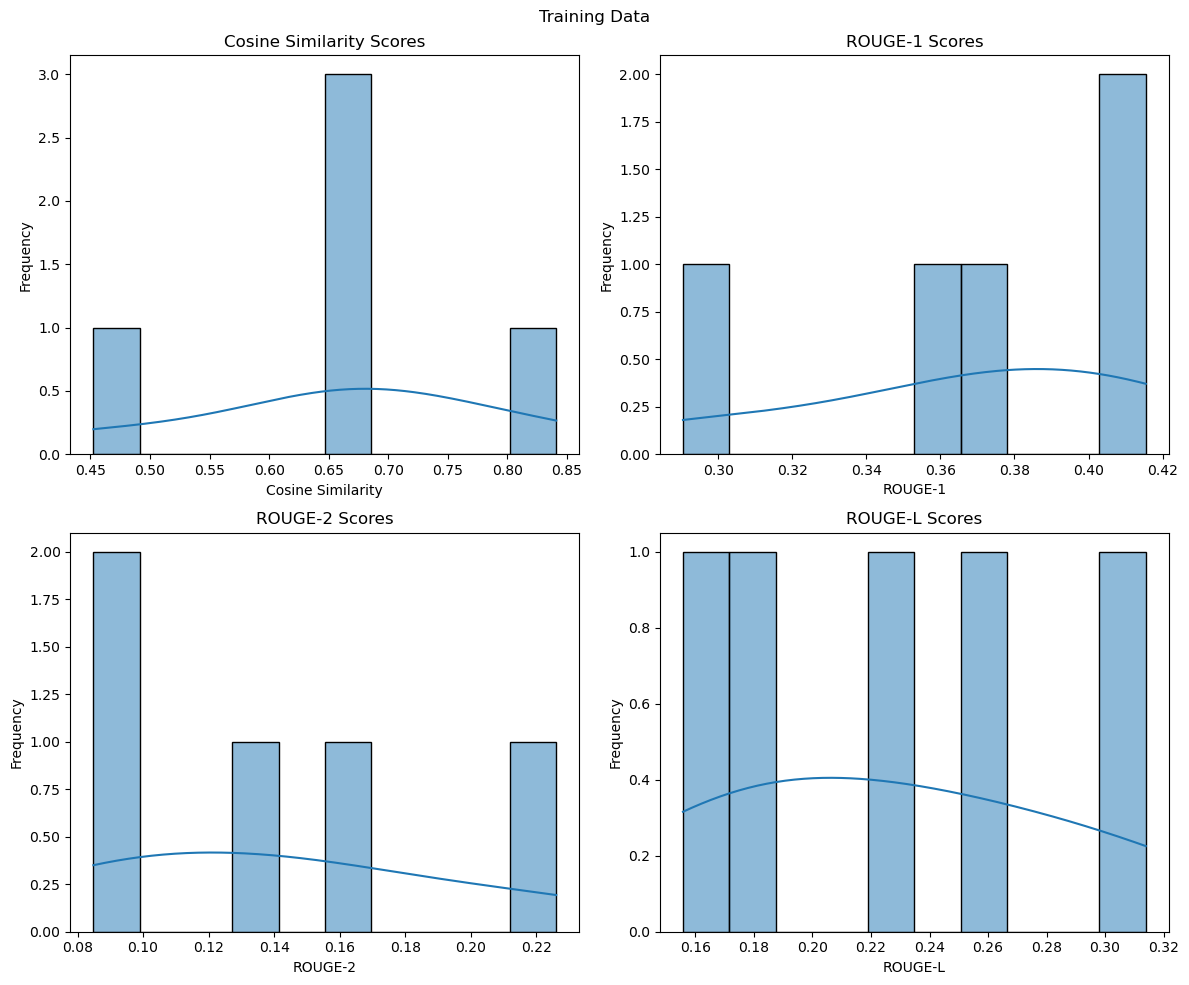

In [78]:
# Create subplots for histograms with KDE for Cosine Similarities and ROUGE Scores
cosine_similarity_scores = train_bart["cosine_similarity_"]
rouge_1_scores = train_bart["rouge_1"]
rouge_2_scores = train_bart["rouge_2"]
rouge_L_scores = train_bart["rouge_L"]


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Cosine Similarity subplot
sns.histplot(cosine_similarity_scores, kde=True, bins=10, ax=axes[0, 0])
axes[0, 0].set_title('Cosine Similarity Scores')
axes[0, 0].set_xlabel('Cosine Similarity')
axes[0, 0].set_ylabel('Frequency')

# ROUGE-1 subplot
sns.histplot(rouge_1_scores, kde=True, bins=10, ax=axes[0, 1])
axes[0, 1].set_title('ROUGE-1 Scores')
axes[0, 1].set_xlabel('ROUGE-1')
axes[0, 1].set_ylabel('Frequency')

# ROUGE-2 subplot
sns.histplot(rouge_2_scores, kde=True, bins=10, ax=axes[1, 0])
axes[1, 0].set_title('ROUGE-2 Scores')
axes[1, 0].set_xlabel('ROUGE-2')
axes[1, 0].set_ylabel('Frequency')

# ROUGE-L subplot
sns.histplot(rouge_L_scores, kde=True, bins=10, ax=axes[1, 1])
axes[1, 1].set_title('ROUGE-L Scores')
axes[1, 1].set_xlabel('ROUGE-L')
axes[1, 1].set_ylabel('Frequency')

plt.suptitle('Training Data')
plt.tight_layout()
plt.show()

In [79]:
avg_rouge_1 = train_bart["rouge_1"].mean()
avg_rouge_2 = train_bart["rouge_2"].mean()
avg_rouge_L = train_bart["rouge_L"].mean()

rouge_df = pd.DataFrame([[avg_rouge_1, avg_rouge_2, avg_rouge_L]], columns=["ROUGE-1", "ROUGE-2", "ROUGE-L"], index=["BART"])
rouge_df

,ROUGE-1,ROUGE-2,ROUGE-L
BART,0.367122,0.14134,0.226389
